# PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio


In [180]:
### PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio

# Step 1: Import modules and define constants
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from scipy import interpolate
from scipy import stats
import plotly.express as px
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [181]:
# Step 2: Data retrieval and Visualisation
def download_data():
    # name of stock as key, stock values 2010-2023
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [182]:
# Step 3: Returns calculation and Portfolio Statistics
# To calculate return using normalisation, show statistics using annual metrics
def calculate_return(data):
    # Normalization - to measure variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]                    # Don't need first row of dataset, since values are NaN

def show_statistics(returns):
    # Instead of daily metrics, use annual metrics
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS
    print("Annual Mean Returns:")
    print(annual_mean)
    print("Annual Covariance Matrix:")
    print(annual_covariance)

In [183]:
# Step 4: To visaulise efficient frontier and display portfolio metrics
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


# Generate multiple portfolios: Display their efficient frontier
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [184]:
# Step 5: Portfolio Generation
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # Generate random weight
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_mean = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_risk = np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w)))
        portfolio_means.append(portfolio_mean)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [185]:
# Step 6: Portfolio Optimization Functions
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Scipy optimize module can find the minimum of a given function
# Maximum of f(x) is minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Constraints: Sum of weights = 1
# f(x) = 0 this is the function to minimize
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Weights can be 1 at most: 1 when 100% of money invested in single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)


In [186]:
# Step 7: Portfolio Results Presentation
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio weights:", optimum['x'].round(3))
    expected_return, volatility, sharpe_ratio = statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {expected_return}")
    print(f"Expected volatility (standard deviation): {volatility}")
    print(f"Sharpe ratio: {sharpe_ratio}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

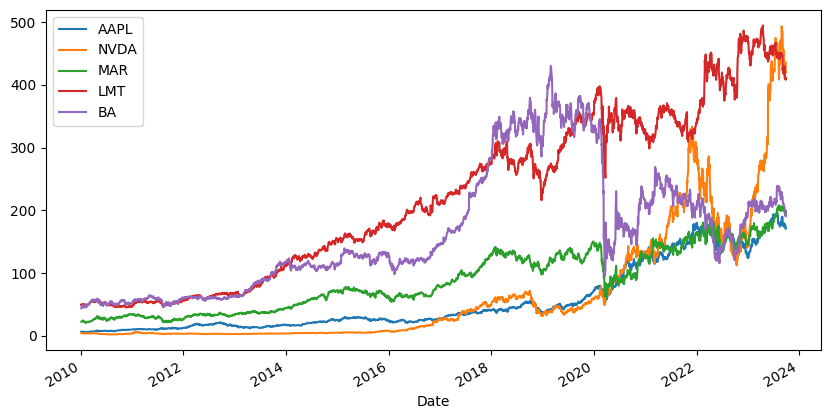



Annual Mean Returns:
AAPL    0.238519
NVDA    0.337450
MAR     0.157839
LMT     0.153483
BA      0.107614
dtype: float64
Annual Covariance Matrix:
          AAPL      NVDA       MAR       LMT        BA
AAPL  0.080627  0.064419  0.036103  0.021053  0.041491
NVDA  0.064419  0.200282  0.054602  0.025807  0.060011
MAR   0.036103  0.054602  0.098672  0.022343  0.065004
LMT   0.021053  0.025807  0.022343  0.044809  0.036176
BA    0.041491  0.060011  0.065004  0.036176  0.130475




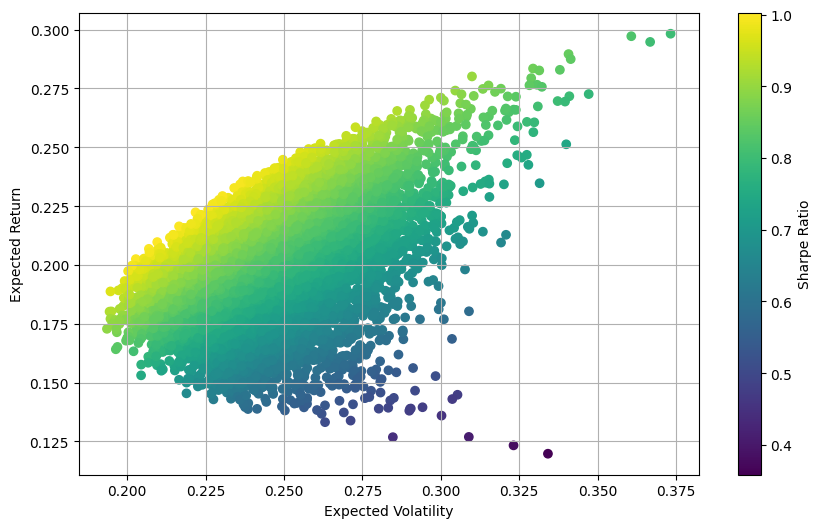



Optimal portfolio weights: [0.364 0.182 0.005 0.45  0.   ]
Expected return: 0.21809330003442015
Expected volatility (standard deviation): 0.21536938649700074
Sharpe ratio: 1.0126476356817655


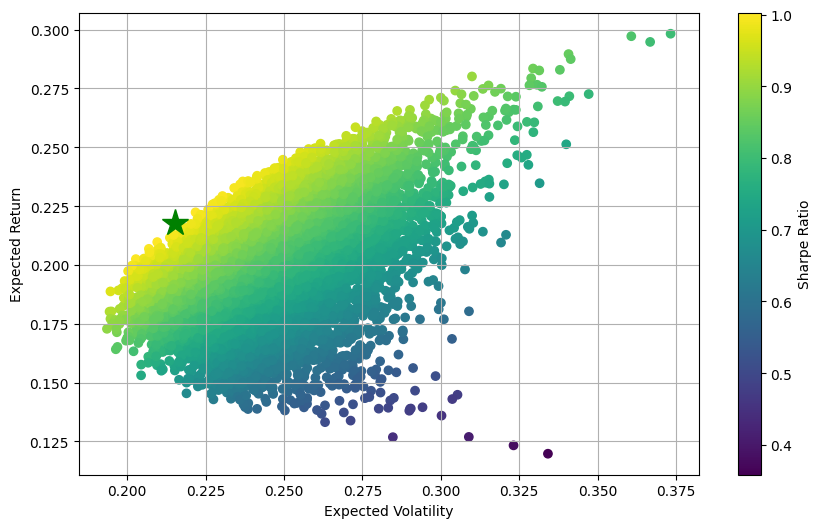

In [187]:
# Main Workflow
# First output: Display stock prices of the 5 stocks, using yfinance
dataset = download_data()
show_data(dataset)
print('\n')

# Second output: Annual Mean returns and covariance matrix of stocks in portfolio
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)
print('\n')

# Third output: Display Scatterplot of expected return against expected volatility, color coded by sharpe ratio
weights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
print('\n')

# Fourth output: Display most optimal portfolio (highest sharpe ratio), denoted by green star
# Each value in the list for optimal portfolio shows the corresponding optimal percentage each stock should take in portfolio
optimum = optimize_portfolio(weights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

# Part 2: Incorporating sentiment score of earnings call and technical indicators with stock data

In [188]:
### PART 2: Analysing of the 5 stock prices, with incorporation of their corresponding sentiment score (extracted using NLP and FinBert)
### NOTE: Wil not be forecasting prices because there are measured in absolute terms and thus harder to compare across time and other assets.
###       Hence, will be forecasting daily returns instead

# Step 1: Import modules and load data
import yfinance as yf
import math
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [189]:
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']
# stocks = []
stock_data = yf.download(stocks, start='2010-01-01', end='2023-10-20', group_by='tickers')
stock_data.head()

[*********************100%%**********************]  5 of 5 completed


NVDA                                                   LMT  \
              Open   High     Low   Close Adj Close    Volume       Open   
Date                                                                       
2010-01-04  4.6275  4.655  4.5275  4.6225  4.240801  80020400  75.870003   
2010-01-05  4.6050  4.740  4.6050  4.6900  4.302726  72864800  76.620003   
2010-01-06  4.6875  4.730  4.6425  4.7200  4.330250  64916800  76.099998   
2010-01-07  4.6950  4.715  4.5925  4.6275  4.245389  54779200  76.169998   
2010-01-08  4.5900  4.670  4.5625  4.6375  4.254563  47816800  74.349998   

                                             ...      AAPL            \
                 High        Low      Close  ...       Low     Close   
Date                                         ...                       
2010-01-04  76.949997  75.519997  76.849998  ...  7.585000  7.643214   
2010-01-05  77.790001  76.550003  77.650002  ...  7.616071  7.656429   
2010-01-06  77.190002  75.849998  76.510002  ...  7.526786  7.534643   
2010-01-07  76.199997  73.610001  74.410004  ...  7.466071  7.520714   
2010-01-08  75.940002  74.320000  75.610001  ...  7.466429  7.570714   

                                        BA                                   \
           Adj Close     Volume       Open       High        Low      Close   
Date                                                                          
2010-01-04  6.487534  493729600  55.720001  56.389999  54.799999  56.180000   
2010-01-05  6.498751  601904800  56.250000  58.279999  56.000000  58.020000   
2010-01-06  6.395378  552160000  58.230000  59.990002  57.880001  59.779999   
2010-01-07  6.383555  477131200  59.509998  62.310001  59.020000  62.200001   
2010-01-08  6.425996  447610800  61.540001  61.779999  60.860001  61.599998   

                                 
            Adj Close    Volume  
Date                             
2010-01-04  43.777554   6186700  
2010-01-05  45.211353   8867800  
2010-01-06  46.582802   8836500  
2010-01-07  48.468559  14379100  
2010-01-08  48.001015   7146600  

[5 rows x 30 columns]

In [190]:
# Step 2: Clean and explore data
stock_data.describe()

NVDA                                                      \
              Open         High          Low        Close    Adj Close   
count  3473.000000  3473.000000  3473.000000  3473.000000  3473.000000   
mean     67.350733    68.593902    66.066085    67.381228    67.105124   
std      98.896408   100.733723    96.943027    98.886316    98.920440   
min       2.180000     2.262500     2.162500     2.220000     2.036686   
25%       4.182500     4.250000     4.107500     4.185000     3.839427   
50%      23.025000    23.152500    22.512501    22.955000    22.627165   
75%      78.074997    79.080002    75.947502    78.025002    77.774612   
max     502.160004   502.660004   489.579987   493.549988   493.509338   

                             LMT                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.473000e+03  3473.000000  3473.000000  3473.000000  3473.000000  ...   
mean   5.068752e+07   250.547558   252.693110   248.401342   250.563409  ...   
std    3.143003e+07   129.657013   130.908460   128.383067   129.615066  ...   
min    4.564400e+06    66.989998    68.400002    66.360001    66.870003  ...   
25%    3.074880e+07   106.910004   107.709999   106.260002   107.050003  ...   
50%    4.351480e+07   255.100006   257.000000   252.770004   254.970001  ...   
75%    6.167640e+07   362.299988   365.579987   359.450012   361.989990  ...   
max    3.692928e+08   502.000000   508.100006   498.000000   501.410004  ...   

              AAPL                                                   BA  \
               Low        Close    Adj Close        Volume         Open   
count  3473.000000  3473.000000  3473.000000  3.473000e+03  3473.000000   
mean     57.488376    58.135312    56.176044  2.449506e+08   173.790193   
std      53.084844    53.719198    54.152633  2.208448e+08    94.181145   
min       6.794643     6.858929     5.821837  3.145820e+07    55.720001   
25%      19.245001    19.445356    16.960625  9.453760e+07   100.250000   
50%      31.719999    31.950001    28.829899  1.550880e+08   145.960007   
75%      79.125000    79.750000    78.009254  3.325616e+08   218.889999   
max     195.279999   196.449997   196.185074  1.880998e+09   446.010010   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3473.000000  3473.000000  3473.000000  3473.000000  3.473000e+03  
mean    175.828304   171.682289   173.751471   164.182916  7.310036e+06  
std      95.270987    93.042401    94.168854    96.619565  8.694362e+06  
min      56.389999    54.799999    56.180000    43.777554  7.889000e+05  
25%     102.419998    99.300003   100.750000    86.017105  3.443600e+06  
50%     147.270004   143.979996   145.860001   132.949997  4.725000e+06  
75%     222.300003   215.910004   218.110001   218.110001  7.371100e+06  
max     446.010010   440.190002   440.619995   430.299988  1.032128e+08  

[8 rows x 30 columns]

In [191]:
# Check for presence of missing values
missing_values_count = stock_data.isnull().sum()
missing_values_count

NVDA  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
LMT   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
MAR   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
AAPL  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
BA    Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
dtype: int64

In [192]:
# Check shape of dataframe
stock_data.shape

(3473, 30)

In [193]:
# Check columns of dataframe
stock_data.columns

MultiIndex([('NVDA',      'Open'),
            ('NVDA',      'High'),
            ('NVDA',       'Low'),
            ('NVDA',     'Close'),
            ('NVDA', 'Adj Close'),
            ('NVDA',    'Volume'),
            ( 'LMT',      'Open'),
            ( 'LMT',      'High'),
            ( 'LMT',       'Low'),
            ( 'LMT',     'Close'),
            ( 'LMT', 'Adj Close'),
            ( 'LMT',    'Volume'),
            ( 'MAR',      'Open'),
            ( 'MAR',      'High'),
            ( 'MAR',       'Low'),
            ( 'MAR',     'Close'),
            ( 'MAR', 'Adj Close'),
            ( 'MAR',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL', 'Adj Close'),
            ('AAPL',    'Volume'),
            (  'BA',      'Open'),
            (  'BA',      'High'),
            (  'BA',       'Low'),
            (  'BA',     'Close'),
            (  'BA',

In [194]:
aapl = yf.Ticker('AAPL')

# YFinance returned error 404
# aapl.info

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Line charts for AAPL: 



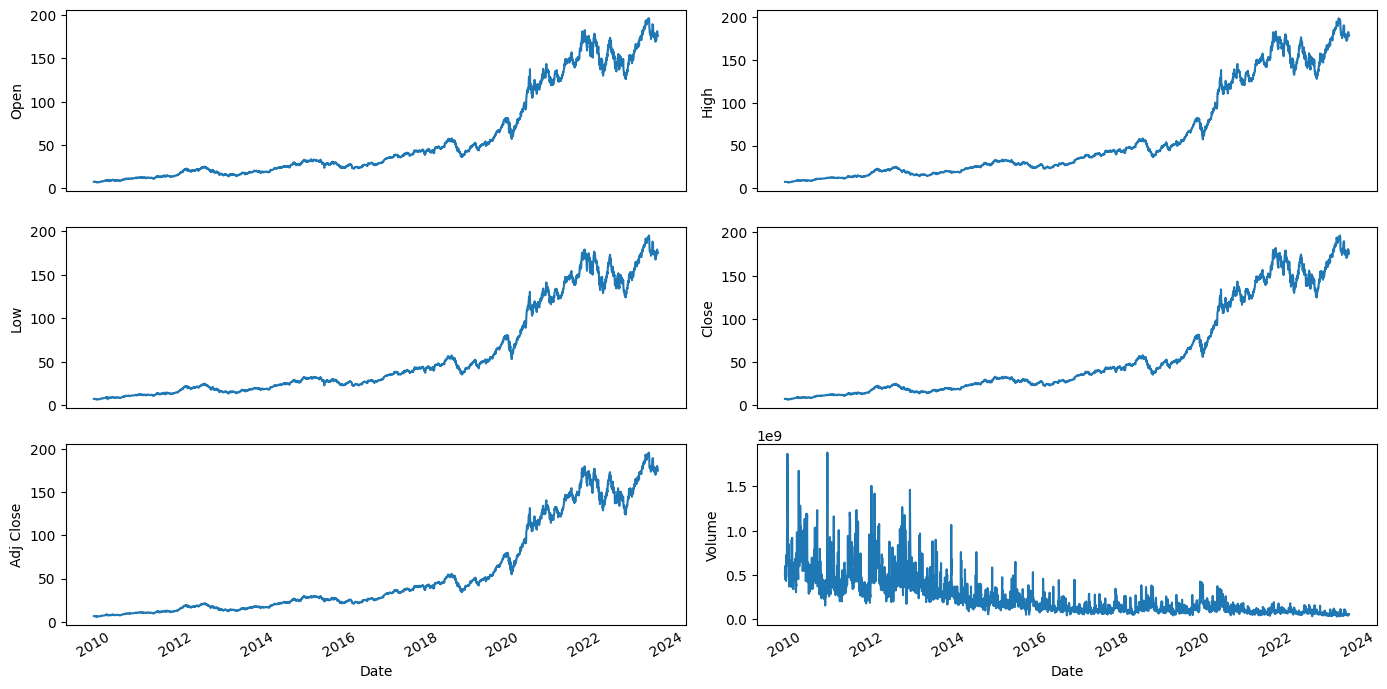

Line charts for NVDA: 



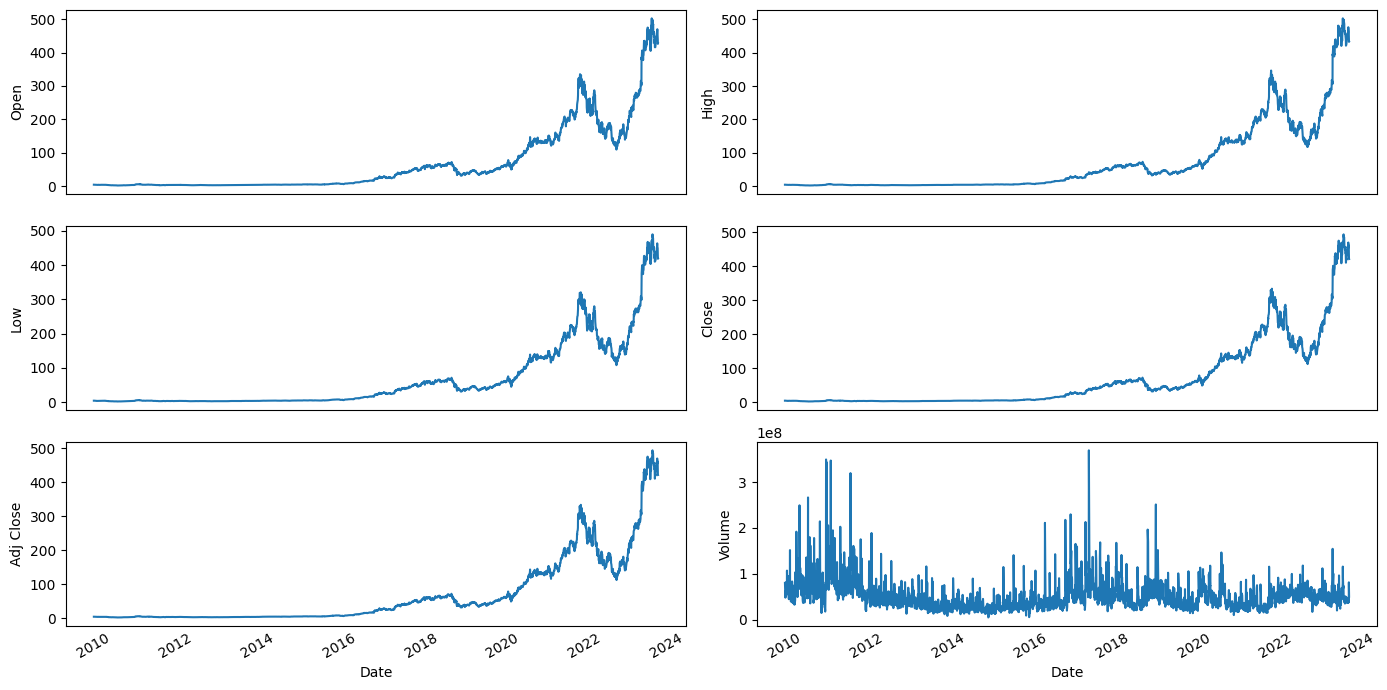

Line charts for MAR: 



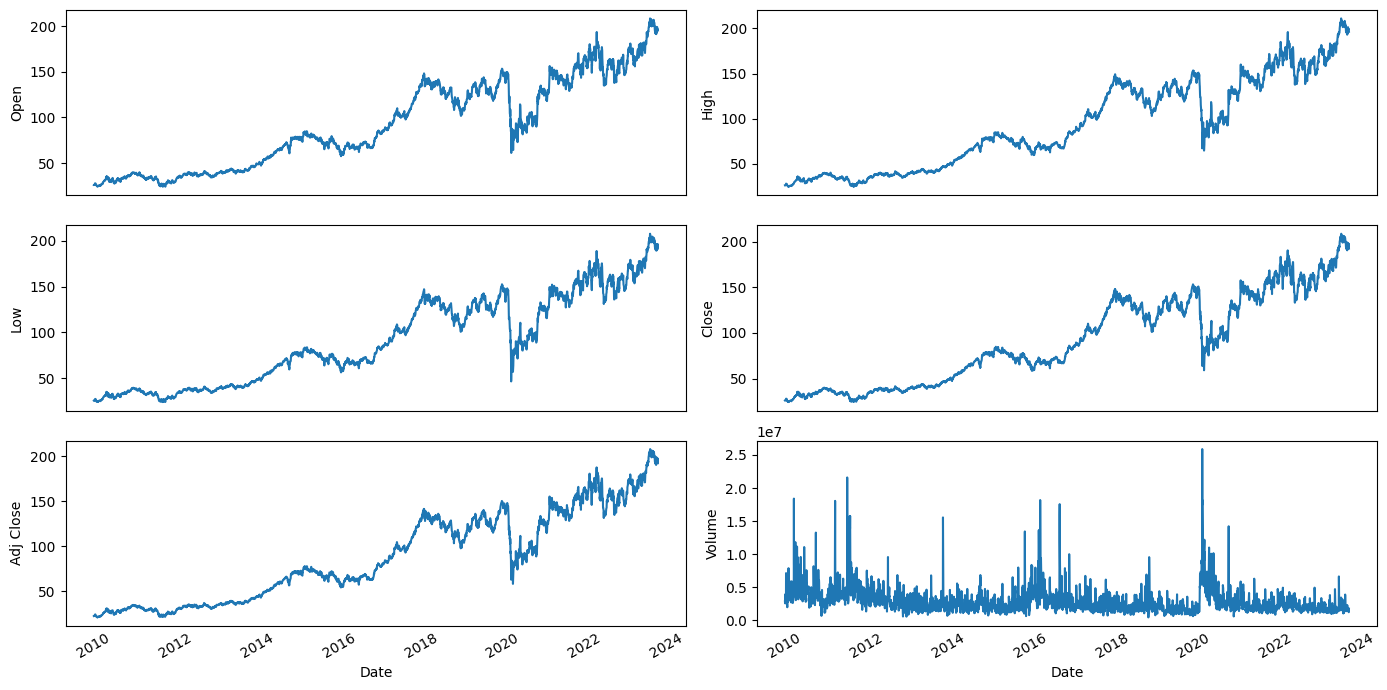

Line charts for LMT: 



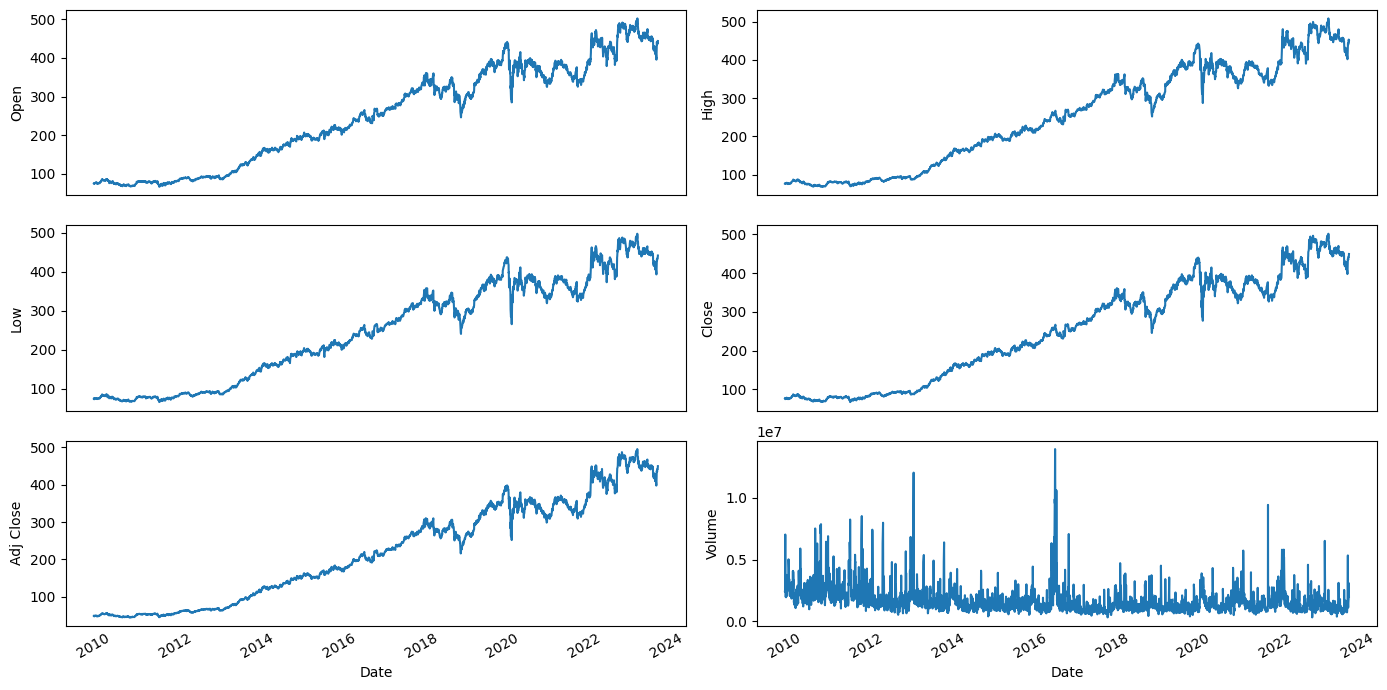

Line charts for BA: 



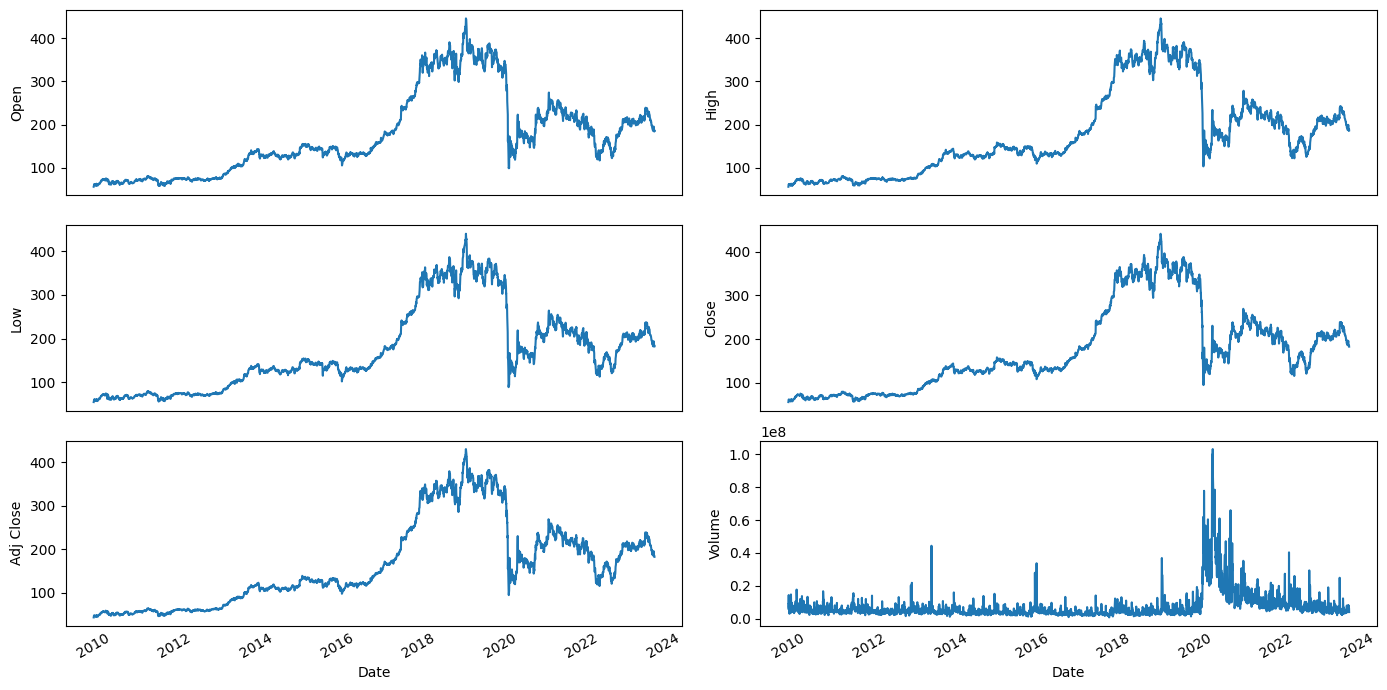

In [195]:
# Explore data: Create line charts for columns of dataset
# Define the DataFrame to plot (Will display line charts for 5 stocks separately here for ease of visualisation)
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-10-20')
nvda_df = yf.download('NVDA', start='2010-01-01', end='2023-10-20')
mar_df = yf.download('MAR', start='2010-01-01', end='2023-10-20')
lmt_df = yf.download('LMT', start='2010-01-01', end='2023-10-20')
ba_df = yf.download('BA', start='2010-01-01', end='2023-10-20')

# Function to plot line chart of every stock in stock_df (For a quick glance)
def plot_line_charts(stock_df):
    # Plot line charts
    df_plot = stock_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

print("Line charts for AAPL: \n")
plot_line_charts(aapl_df)
print("Line charts for NVDA: \n")
plot_line_charts(nvda_df)
print("Line charts for MAR: \n")
plot_line_charts(mar_df)
print("Line charts for LMT: \n")
plot_line_charts(lmt_df)
print("Line charts for BA: \n")
plot_line_charts(ba_df)

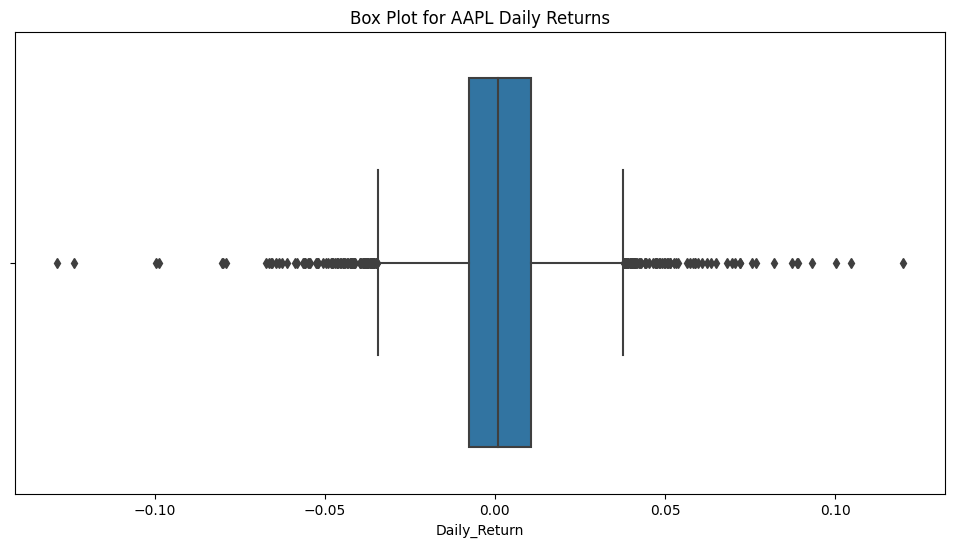

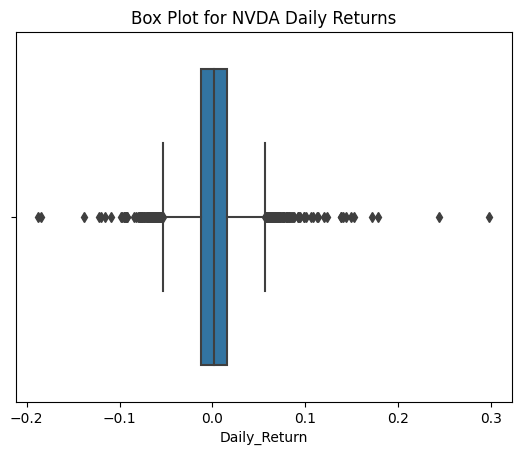

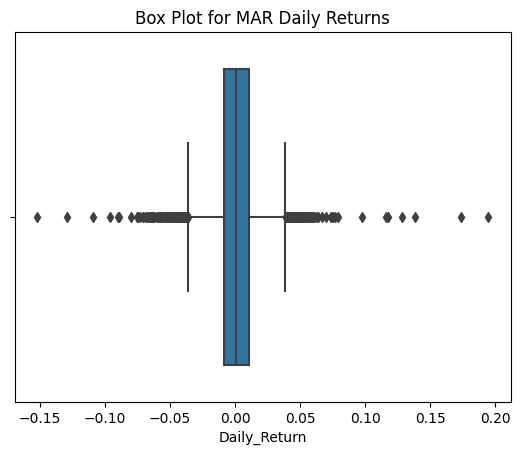

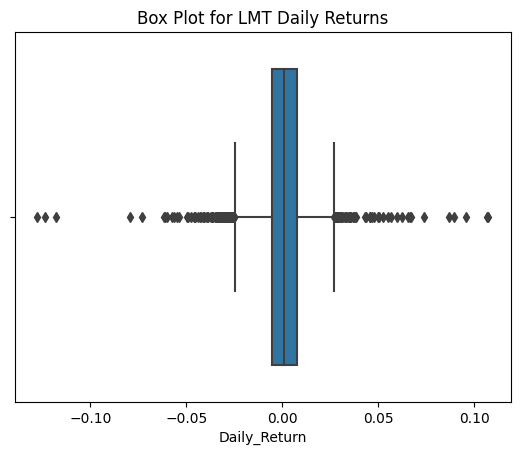

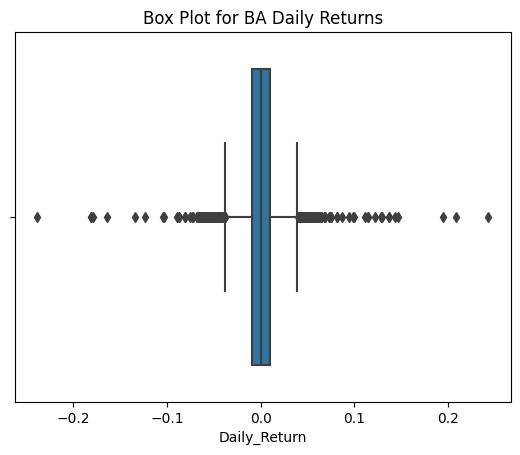

In [196]:
# Step 3: Feature Engineering
# Forecast daily returns by creating return column and analyse possible outliers using boxplot

for stock in stocks:
    stock_data[stock, 'Daily_Return'] = stock_data[stock]['Adj Close'].pct_change()
    stock_data = stock_data.sort_index(axis=1)

# Perform data analysis to identify possible outliers
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.boxplot(x=stock_data[stock]["Daily_Return"])
    plt.title(f'Box Plot for {stock} Daily Returns')
    plt.show()
    print("\n")

In [197]:
# Since we feel that outliers are meaningful and representative of actual market conditions/events, we decide not to remove them
# Using log transformation to reduce the impact of outliers, instead of removing them
# Will be log tansforming the outliers to certain features in dataframe merged

stock_data.head()

AAPL                                                       \
           Adj Close     Close Daily_Return      High       Low      Open   
Date                                                                        
2010-01-04  6.487534  7.643214          NaN  7.660714  7.585000  7.622500   
2010-01-05  6.498751  7.656429     0.001729  7.699643  7.616071  7.664286   
2010-01-06  6.395378  7.534643    -0.015907  7.686786  7.526786  7.656429   
2010-01-07  6.383555  7.520714    -0.001849  7.571429  7.466071  7.562500   
2010-01-08  6.425996  7.570714     0.006648  7.571429  7.466429  7.510714   

                              BA                          ...        MAR  \
               Volume  Adj Close      Close Daily_Return  ...        Low   
Date                                                      ...              
2010-01-04  493729600  43.777554  56.180000          NaN  ...  25.636192   
2010-01-05  601904800  45.211353  58.020000     0.032752  ...  25.796417   
2010-01-06  552160000  46.582802  59.779999     0.030334  ...  25.947220   
2010-01-07  477131200  48.468559  62.200001     0.040482  ...  26.107447   
2010-01-08  447610800  48.001015  61.599998    -0.009646  ...  26.163996   

                                    NVDA                                      \
                 Open   Volume Adj Close   Close Daily_Return   High     Low   
Date                                                                           
2010-01-04  26.022619  2860350  4.240801  4.6225          NaN  4.655  4.5275   
2010-01-05  25.984921  2627885  4.302726  4.6900     0.014602  4.740  4.6050   
2010-01-06  26.145145  2789900  4.330250  4.7200     0.006397  4.730  4.6425   
2010-01-07  26.154572  2560724  4.245389  4.6275    -0.019597  4.715  4.5925   
2010-01-08  26.182846  3961031  4.254563  4.6375     0.002161  4.670  4.5625   

                              
              Open    Volume  
Date                          
2010-01-04  4.6275  80020400  
2010-01-05  4.6050  72864800  
2010-01-06  4.6875  64916800  
2010-01-07  4.6950  54779200  
2010-01-08  4.5900  47816800  

[5 rows x 35 columns]

#Import Sentiment score from Excel

In [198]:
# Adding text sentiment score as an additional column to dataframe

# Import excel data of sentiment score as dataframe
df_sentiment_score = pd.read_excel("sentiment_score.xlsx")
df_sentiment_score

,filename,sentiment_score
0,2016-Jan-28-BA.N-138020839119-Transcript.txt,0.290381
1,2015-Apr-22-BA.N-140063175207-Transcript.txt,0.187387
2,2022-Oct-26-BA.N-140697322944-Transcript.txt,0.086556
3,2010-Jul-28-BA.N-137028827968-Transcript.txt,0.052885
4,2014-Jan-29-BA.N-139067099110-Transcript.txt,0.257669
...,...,...
269,2017-May-03-AAPL.OQ-137410537849-Transcript.txt,0.266504
270,2015-Oct-28-AAPL.OQ-139180636945-Transcript.txt,0.286697
271,2012-Jul-25-AAPL.OQ-138648438585-Transcript.txt,0.175141
272,2011-Apr-21-AAPL.OQ-140555924186-Transcript.txt,0.204651


In [199]:
# Convert filename column, data will be in the format of YYYY-MM-DD.TickerName
def convert_column(filename):
    file_name_splitted = filename.split('.')
    final_file_name = ""
    month_to_numeric = {"Jan": "01",
                        "Feb": "02",
                        "Mar": "03",
                        "Apr": "04",
                        "May": "05",
                        "Jun": "06",
                        "Jul": "07",
                        "Aug": "08",
                        "Sep": "09",
                        "Oct": "10",
                        "Nov": "11",
                        "Dec": "12"
                        }

    splitted_by_dash = file_name_splitted[0].split('-')
    month_alphabet = splitted_by_dash[1]
    month_numeric = month_to_numeric[month_alphabet]
    final_file_name += splitted_by_dash[0] + "-" + month_numeric + "-" + splitted_by_dash[2] + "." + splitted_by_dash[3]

    return final_file_name

df_sentiment_score['filename'] = df_sentiment_score['filename'].apply(convert_column)
df_sentiment_score

,filename,sentiment_score
0,2016-01-28.BA,0.290381
1,2015-04-22.BA,0.187387
2,2022-10-26.BA,0.086556
3,2010-07-28.BA,0.052885
4,2014-01-29.BA,0.257669
...,...,...
269,2017-05-03.AAPL,0.266504
270,2015-10-28.AAPL,0.286697
271,2012-07-25.AAPL,0.175141
272,2011-04-21.AAPL,0.204651


In [200]:
# Function to make the date as row index, while column will be stock ticker
def format_filename(row):
    parts = row['filename'].split('.')
    return pd.Series([parts[0], parts[1], row['sentiment_score']], index=['Date', 'Ticker', 'Sentiment_score'])

# Apply the function to each row and restructure the DataFrame
df_sentiment_score = df_sentiment_score.apply(format_filename, axis=1)

# Set the 'Date' column as the row index
df_sentiment_score.set_index('Date', inplace=True)


In [201]:
df_sentiment_score = df_sentiment_score.groupby("Ticker")

sentiment_score_dict = {}
for stock in stocks:
    suffixed_df = df_sentiment_score.get_group(f"{stock}").add_prefix(f'{stock}_')
    suffixed_df.drop([f"{stock}_Ticker"], axis=1, inplace=True)
    new_df = suffixed_df.reset_index('Date')
    sentiment_score_dict[f'{stock}_df_sentiment_score'] = new_df


In [202]:
stock_data_dict = {}

for stock in stocks:
    suffixed_df = stock_data[f'{stock}'].add_prefix(f'{stock}_')
    new_df = suffixed_df.reset_index('Date')
    new_df['Date'] = new_df['Date'].astype(str)
    stock_data_dict[f'{stock}_stock_data'] = new_df


# Merge sentiment_score dataframe with stock_data dataframe

In [203]:
merged_dict = {}
for stock in stocks:
    new_merged_df = stock_data_dict[f'{stock}_stock_data'].merge(sentiment_score_dict[f'{stock}_df_sentiment_score'], how='outer', on='Date')
    merged_dict[f"{stock}"] = new_merged_df

In [204]:
res = list(merged_dict.keys())[0]
merged = pd.DataFrame(merged_dict[res])
print(merged)

for key, value in merged_dict.items():
    if key != res:
        merged = merged.merge(value, on='Date', how='outer')

merged = merged.sort_values(by=['Date'], ascending=True)
print(merged)

            Date  AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return   AAPL_High  \
0     2010-01-04        6.487534    7.643214                NaN    7.660714   
1     2010-01-05        6.498751    7.656429           0.001729    7.699643   
2     2010-01-06        6.395378    7.534643          -0.015907    7.686786   
3     2010-01-07        6.383555    7.520714          -0.001849    7.571429   
4     2010-01-08        6.425996    7.570714           0.006648    7.571429   
...          ...             ...         ...                ...         ...   
3468  2023-10-13      178.850006  178.850006          -0.010293  181.929993   
3469  2023-10-16      178.720001  178.720001          -0.000727  179.080002   
3470  2023-10-17      177.149994  177.149994          -0.008785  178.419998   
3471  2023-10-18      175.839996  175.839996          -0.007395  177.580002   
3472  2023-10-19      175.460007  175.460007          -0.002161  177.839996   

        AAPL_Low   AAPL_Open  AAPL_Volume  AAPL_Sen

In [205]:
# merged is a dataframe that has 1 additional row than dataframe stock_data because an earnings call by MAR was done on a Saturday (2019-05-11)
merged.head()

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487534,7.643214,NaN,7.660714,7.585000,7.622500,493729600.0,NaN,4.240801,...,2408300.0,NaN,43.777554,56.180000,NaN,56.389999,54.799999,55.720001,6186700.0,NaN
1,2010-01-05,6.498751,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,NaN,4.302726,...,2356500.0,NaN,45.211353,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,NaN
2,2010-01-06,6.395378,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,NaN,4.330250,...,5208100.0,NaN,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,NaN
3,2010-01-07,6.383555,7.520714,-0.001849,7.571429,7.466071,7.562500,477131200.0,NaN,4.245389,...,7038300.0,NaN,48.468559,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,NaN
4,2010-01-08,6.425996,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,NaN,4.254563,...,3629400.0,NaN,48.001015,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,NaN


# Data Cleaning, Exploratory Data Analysis and Feature Engineering

In [206]:
# I Will want to "data clean"/handle outliers for initial columns (e.g: 'Close'), because the technical indicators will need to use these values
# I Will not be performing log transformation to handle outliers for columns: Daily_Return and Volume
# -> Daily_Return (measured as % change in stock's price) can be both +ve and -ve and extreme returns can occur, log transformation not required
# -> Although volume data can have outliers, it will be uesd as it is because unlike price data, it does not have a natural logarithmic interpretation. In fact, outliers in volume may carry valuable information about market events and trading behaviour

# I will be performing log transformation to handle outliers in columns: Adj. CLose, Close, High, Low, Open
# -> These columns are often right-skewed due to presence of extreme price values (stock splits, mergers, market events)
# -> Applying log. transformation to these columns can mitigate impact of outliers and make data more normally distributed

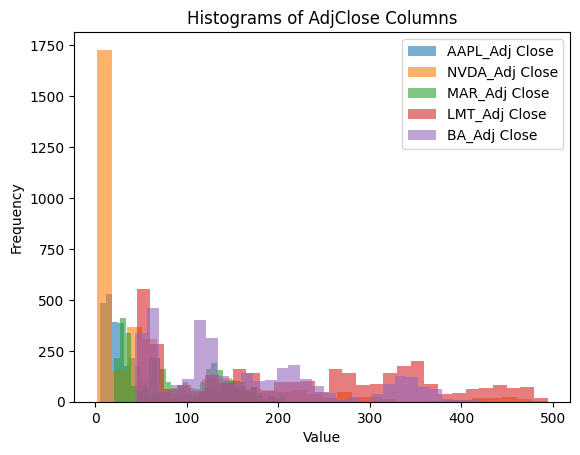

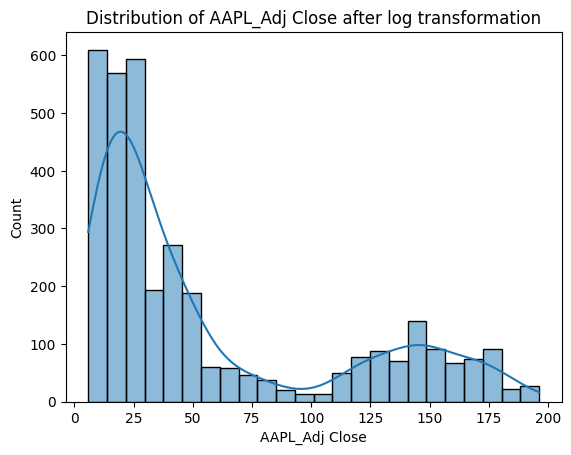

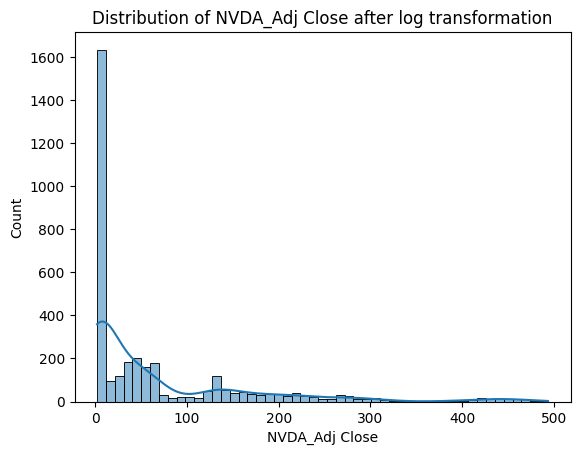

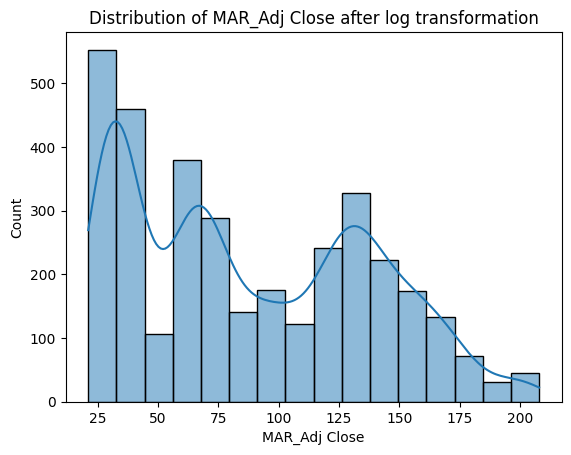

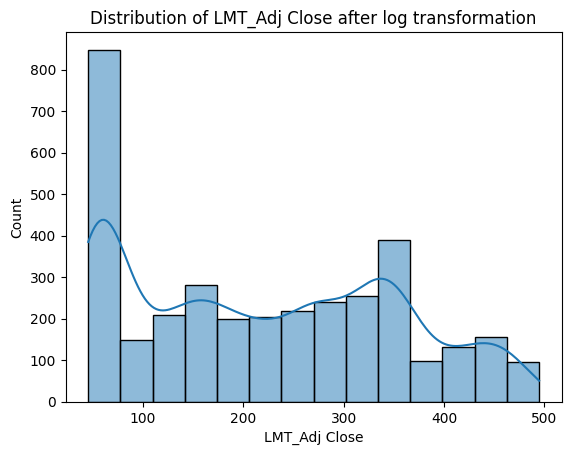

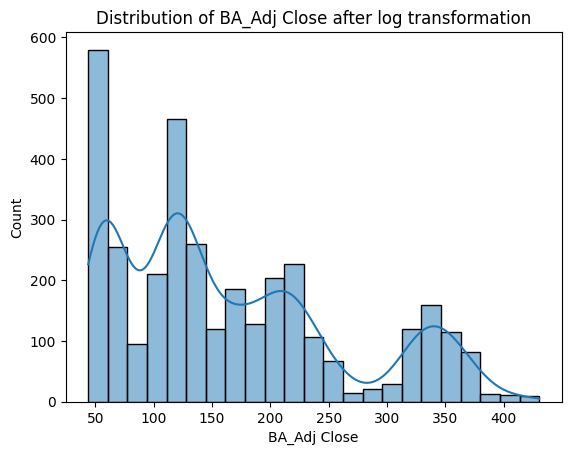

In [207]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Adj Close columns
columns_to_plot = ["AAPL_Adj Close", "NVDA_Adj Close", "MAR_Adj Close", "LMT_Adj Close", "BA_Adj Close"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of AdjClose Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

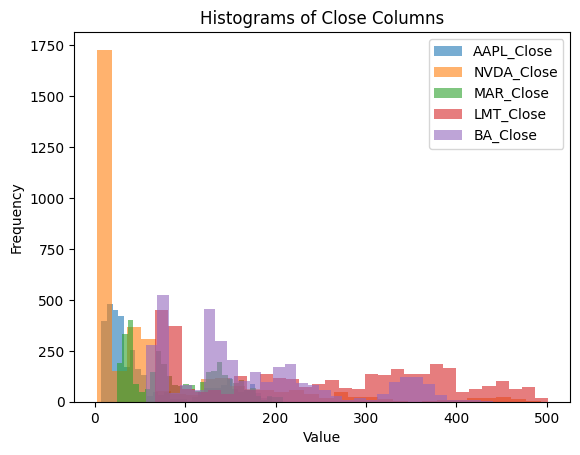

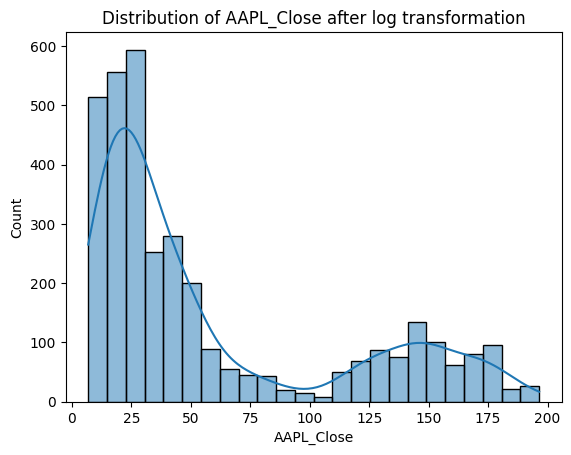

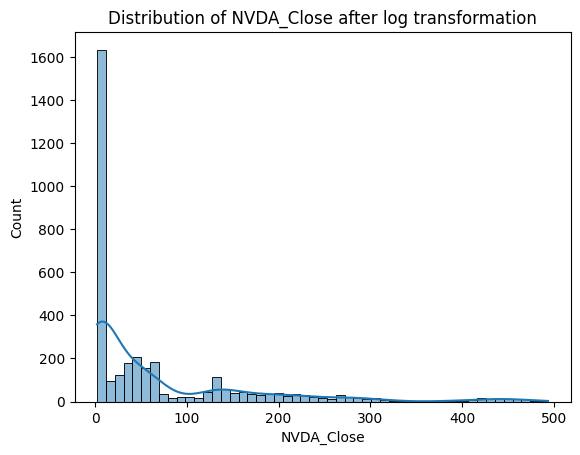

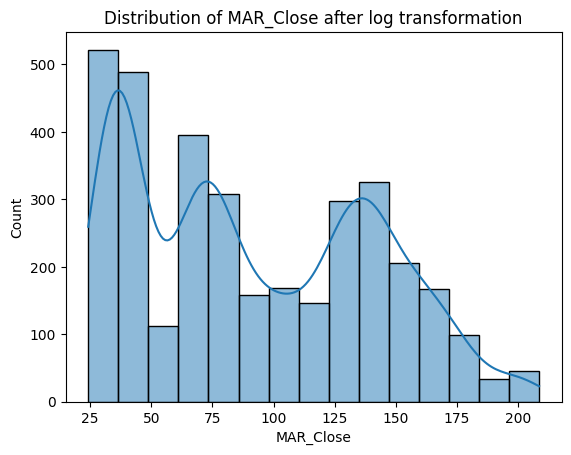

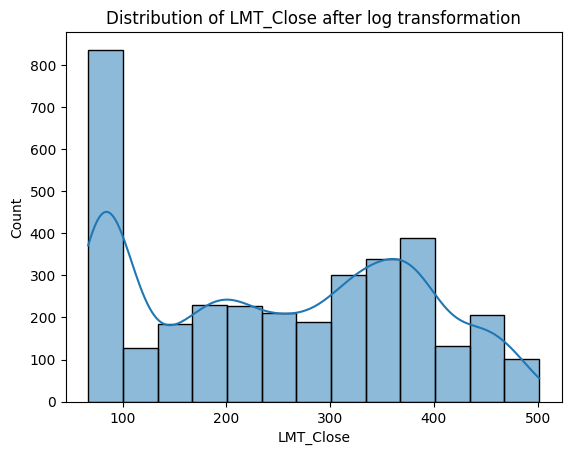

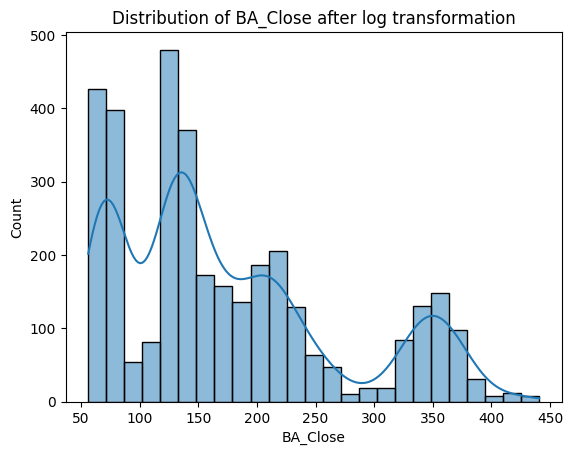

In [208]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Close columns
columns_to_plot = ["AAPL_Close", "NVDA_Close", "MAR_Close", "LMT_Close", "BA_Close"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Close Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

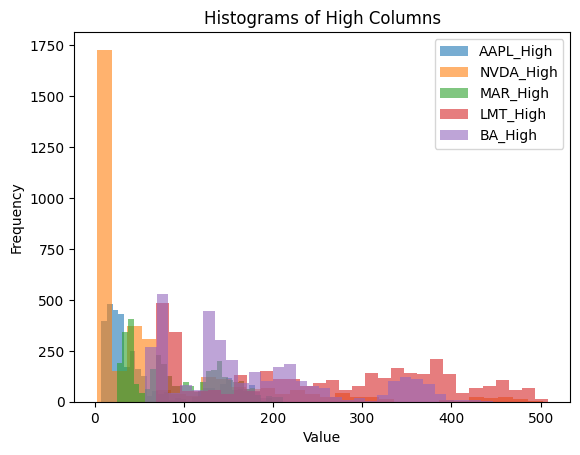

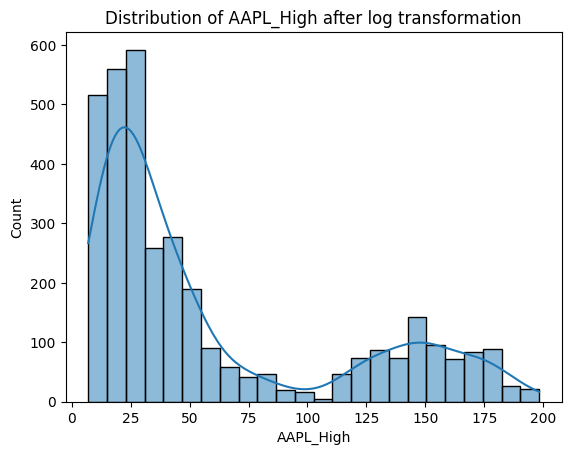

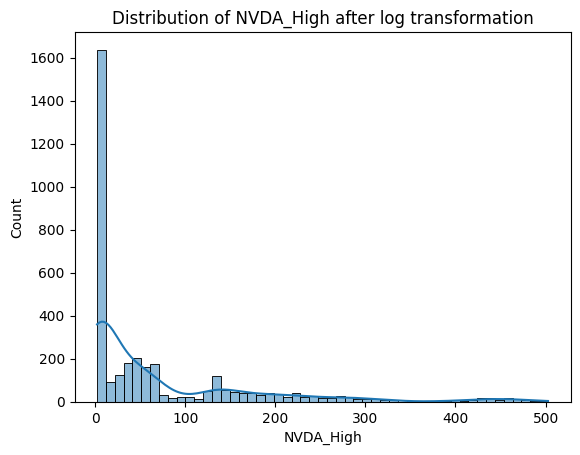

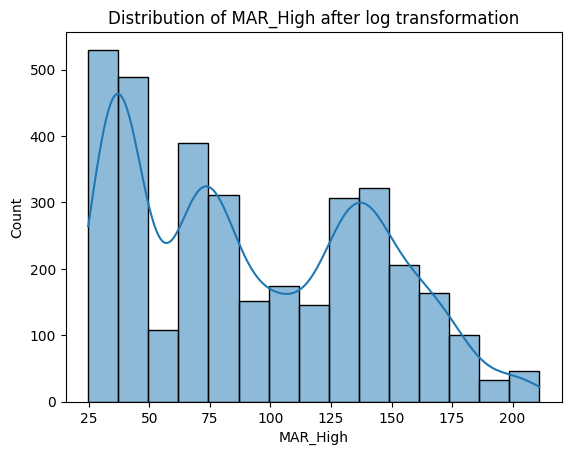

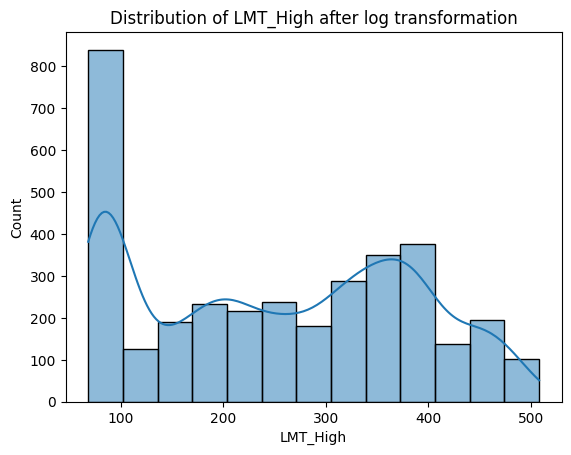

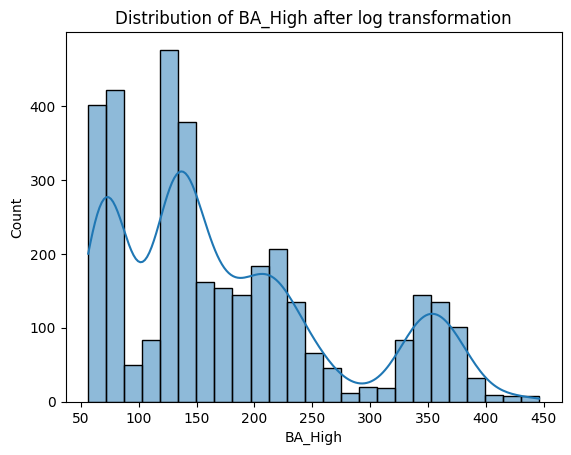

In [209]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For High columns
columns_to_plot = ["AAPL_High", "NVDA_High", "MAR_High", "LMT_High", "BA_High"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of High Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

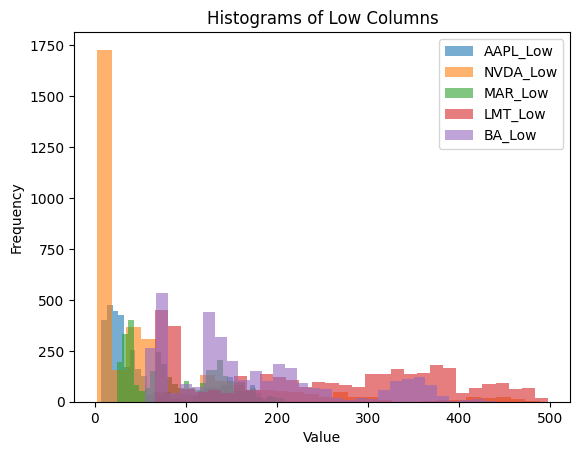

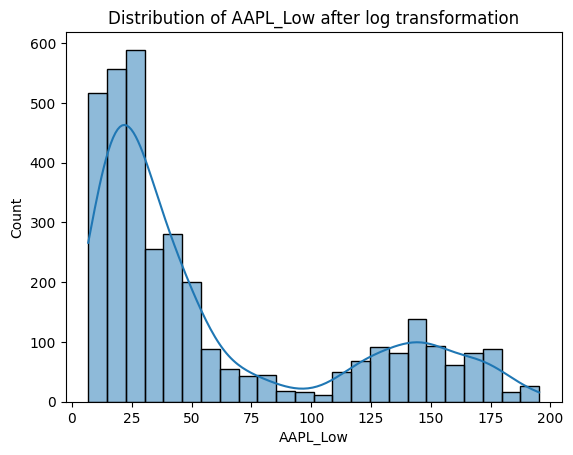

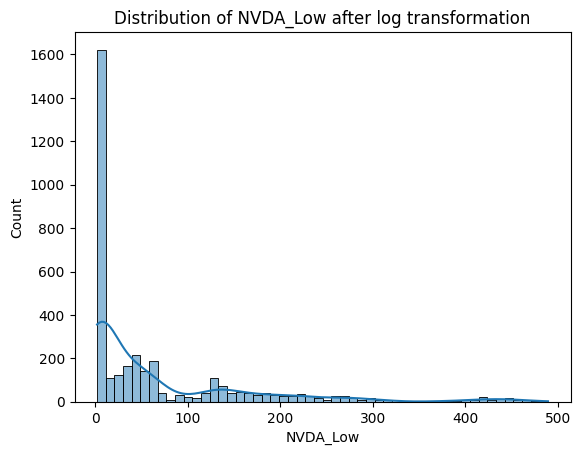

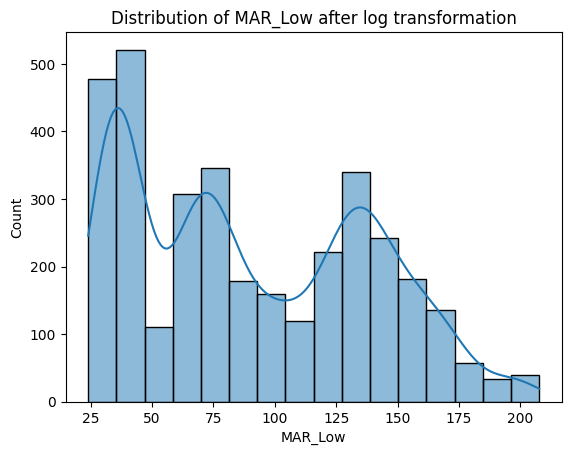

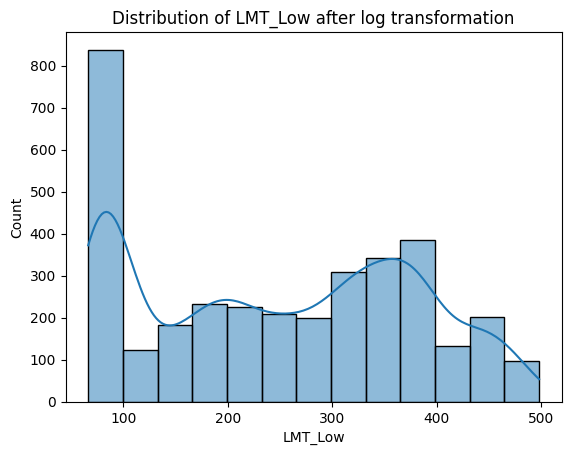

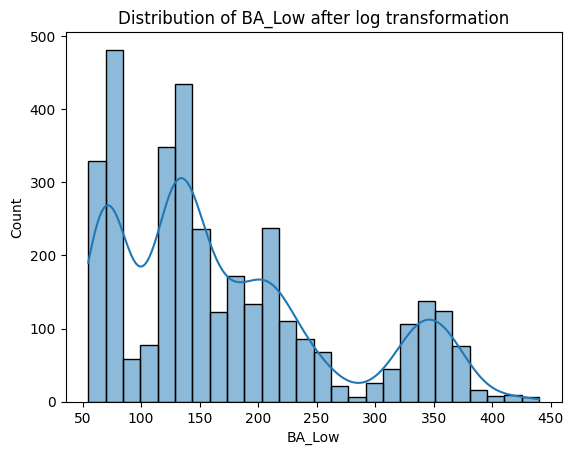

In [210]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Low columns
columns_to_plot = ["AAPL_Low", "NVDA_Low", "MAR_Low", "LMT_Low", "BA_Low"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Low Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

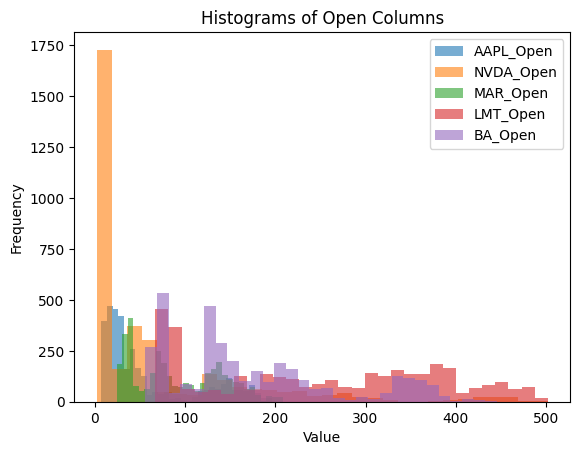

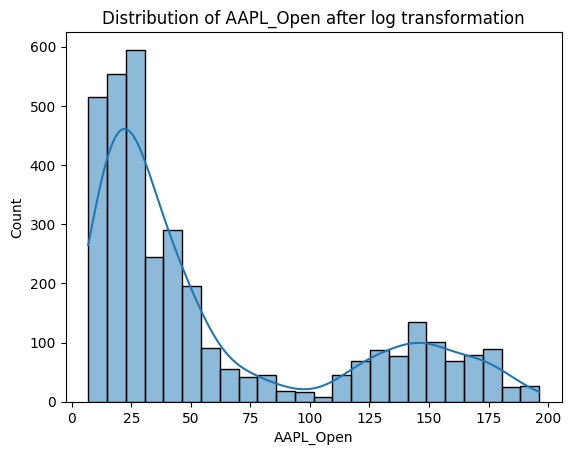

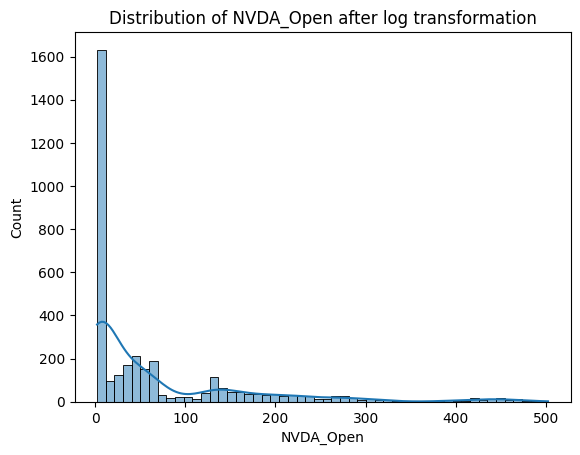

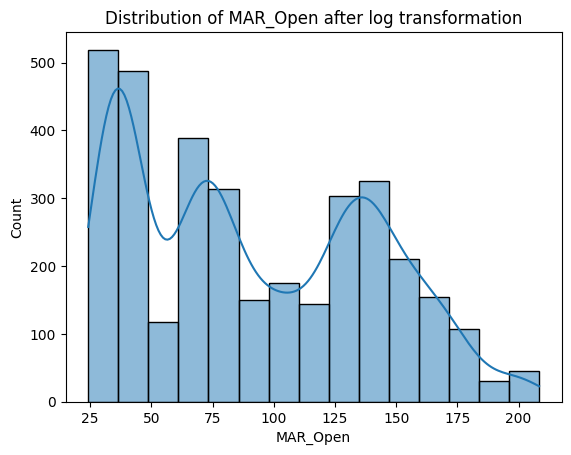

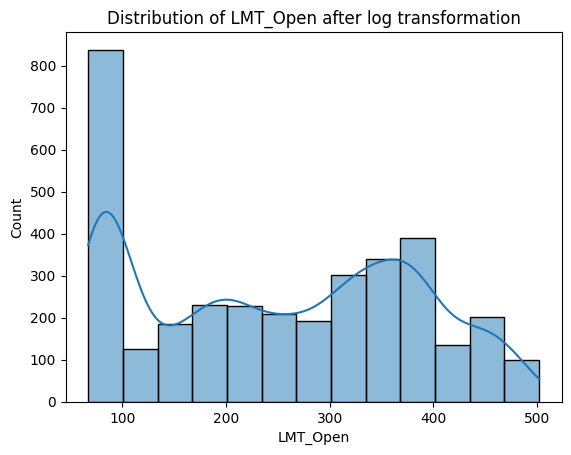

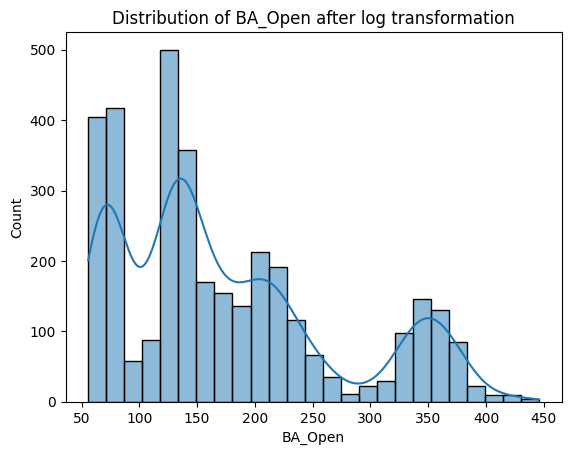

In [211]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For High columns
columns_to_plot = ["AAPL_Open", "NVDA_Open", "MAR_Open", "LMT_Open", "BA_Open"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Open Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

In [212]:
merged        # merged dataframe outliers will now be replaced

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487534,7.643214,NaN,7.660714,7.585000,7.622500,493729600.0,NaN,4.240801,...,2408300.0,NaN,43.777554,56.180000,NaN,56.389999,54.799999,55.720001,6186700.0,NaN
1,2010-01-05,6.498751,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,NaN,4.302726,...,2356500.0,NaN,45.211353,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,NaN
2,2010-01-06,6.395378,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,NaN,4.330250,...,5208100.0,NaN,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,NaN
3,2010-01-07,6.383555,7.520714,-0.001849,7.571429,7.466071,7.562500,477131200.0,NaN,4.245389,...,7038300.0,NaN,48.468559,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,NaN
4,2010-01-08,6.425996,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,NaN,4.254563,...,3629400.0,NaN,48.001015,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,NaN,454.609985,...,1519300.0,NaN,184.910004,184.910004,-0.033403,187.289993,183.179993,186.270004,8215700.0,NaN
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,NaN,460.950012,...,1931300.0,NaN,184.929993,184.929993,0.000108,186.229996,182.500000,185.910004,4701000.0,NaN
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,NaN,439.380005,...,3103900.0,NaN,185.600006,185.600006,0.003623,188.330002,183.300003,183.750000,5121800.0,NaN
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,NaN,421.959991,...,2024100.0,NaN,185.690002,185.690002,0.000485,190.250000,185.050003,187.220001,6268100.0,NaN


In [213]:
# Check for NaN values in any of the columns (except sentiment_score)
# 1st NaN row: first row for Daily_Return  (because there's no return on 'first day')
# 2nd NaN row: I have found out that the NaN value comes from the row 2356 in excel => which is due to: an earnings call by MAR was done on a Saturday (2019-05-11)

# Will be using zero fill to replace (Assume no return on first day) 1st NaN row for "Daily_Return" columns, Using Median to replace 1st NaN row of other columns,

# Check for NaN values in all columns of the DataFrame and count them
nan_counts = merged.isna().sum()

# Display columns with NaN values and the count of NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


zero_fill_columns = ["AAPL_Daily_Return", "NVDA_Daily_Return", "MAR_Daily_Return", "LMT_Daily_Return", "BA_Daily_Return"]
for column in zero_fill_columns:
    if merged[column].isna().any():
        first_nan_index = merged[column].index[merged[column].isna()].tolist()[0]         # Only for the first row of Daily_Return columns
        merged.at[first_nan_index, column] = 0


# Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

columns_to_replace_outliers = ["AAPL_Adj Close", "AAPL_Close", "AAPL_Daily_Return", "AAPL_High", "AAPL_Low", "AAPL_Open", "AAPL_Volume",
                               "NVDA_Adj Close", "NVDA_Close", "NVDA_Daily_Return", "NVDA_High", "NVDA_Low", "NVDA_Open", "NVDA_Volume",
                               "MAR_Adj Close", "MAR_Close", "MAR_Daily_Return", "MAR_High", "MAR_Low", "MAR_Open", "MAR_Volume",
                               "LMT_Adj Close", "LMT_Close", "LMT_Daily_Return", "LMT_High", "LMT_Low", "LMT_Open", "LMT_Volume",
                               "BA_Adj Close", "BA_Close", "BA_Daily_Return", "BA_High", "BA_Low", "BA_Open", "BA_Volume",
                               ]

# Function that replaces NaN values of column with median
def replace_nan_with_median(df, columns_to_process):
    for column in columns_to_process:
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    return df

merged = replace_nan_with_median(merged, columns_to_replace_outliers)

print(merged)


AAPL_Adj Close             1
AAPL_Close                 1
AAPL_Daily_Return          2
AAPL_High                  1
AAPL_Low                   1
AAPL_Open                  1
AAPL_Volume                1
AAPL_Sentiment_score    3419
NVDA_Adj Close             1
NVDA_Close                 1
NVDA_Daily_Return          2
NVDA_High                  1
NVDA_Low                   1
NVDA_Open                  1
NVDA_Volume                1
NVDA_Sentiment_score    3419
MAR_Adj Close              1
MAR_Close                  1
MAR_Daily_Return           2
MAR_High                   1
MAR_Low                    1
MAR_Open                   1
MAR_Volume                 1
MAR_Sentiment_score     3419
LMT_Adj Close              1
LMT_Close                  1
LMT_Daily_Return           2
LMT_High                   1
LMT_Low                    1
LMT_Open                   1
LMT_Volume                 1
LMT_Sentiment_score     3420
BA_Adj Close               1
BA_Close                   1
BA_Daily_Retur

In [214]:
# Interpolate the sentiment scores for all 5 stocks for those non earnings call dates using linear interpolation
columns_to_interpolate = ['AAPL_Sentiment_score', 'NVDA_Sentiment_score', 'MAR_Sentiment_score', 'LMT_Sentiment_score', 'BA_Sentiment_score']  # Replace with your column names
for column in columns_to_interpolate:
    merged[column].interpolate(method='linear', inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3474 entries, 0 to 3472
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3474 non-null   object 
 1   AAPL_Adj Close        3474 non-null   float64
 2   AAPL_Close            3474 non-null   float64
 3   AAPL_Daily_Return     3474 non-null   float64
 4   AAPL_High             3474 non-null   float64
 5   AAPL_Low              3474 non-null   float64
 6   AAPL_Open             3474 non-null   float64
 7   AAPL_Volume           3474 non-null   float64
 8   AAPL_Sentiment_score  3459 non-null   float64
 9   NVDA_Adj Close        3474 non-null   float64
 10  NVDA_Close            3474 non-null   float64
 11  NVDA_Daily_Return     3474 non-null   float64
 12  NVDA_High             3474 non-null   float64
 13  NVDA_Low              3474 non-null   float64
 14  NVDA_Open             3474 non-null   float64
 15  NVDA_Volume           3474

In [215]:
#Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

# Since there are still leftover NaN for sentiment score column, possibly due to presence of consecutive NaN values, I will use backfill to handle them
columns_to_backfill = ['AAPL_Sentiment_score', 'NVDA_Sentiment_score', 'MAR_Sentiment_score', 'LMT_Sentiment_score', 'BA_Sentiment_score']
for column in columns_to_backfill:
    merged[column].fillna(method='bfill', inplace=True)

# Confirm there is no leftover NaN values
nan_counts_new = merged.isna().sum()
columns_with_nan_new = nan_counts_new[nan_counts > 0]
print(columns_with_nan_new)

AAPL_Sentiment_score    15
NVDA_Sentiment_score    31
MAR_Sentiment_score     27
LMT_Sentiment_score     18
BA_Sentiment_score      16
dtype: int64
AAPL_Sentiment_score    0
NVDA_Sentiment_score    0
MAR_Sentiment_score     0
LMT_Sentiment_score     0
BA_Sentiment_score      0
dtype: int64


In [216]:
merged

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487534,7.643214,0.000000,7.660714,7.585000,7.622500,493729600.0,0.189922,4.240801,...,2408300.0,0.123229,43.777554,56.180000,0.000000,56.389999,54.799999,55.720001,6186700.0,0.118022
1,2010-01-05,6.498751,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,0.189922,4.302726,...,2356500.0,0.123229,45.211353,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,0.118022
2,2010-01-06,6.395378,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,0.189922,4.330250,...,5208100.0,0.123229,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,0.118022
3,2010-01-07,6.383555,7.520714,-0.001849,7.571429,7.466071,7.562500,477131200.0,0.189922,4.245389,...,7038300.0,0.123229,48.468559,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,0.118022
4,2010-01-08,6.425996,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,0.189922,4.254563,...,3629400.0,0.123229,48.001015,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,0.118022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,0.300216,454.609985,...,1519300.0,0.234343,184.910004,184.910004,-0.033403,187.289993,183.179993,186.270004,8215700.0,0.207792
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,0.300216,460.950012,...,1931300.0,0.234343,184.929993,184.929993,0.000108,186.229996,182.500000,185.910004,4701000.0,0.207792
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,0.300216,439.380005,...,3103900.0,0.234343,185.600006,185.600006,0.003623,188.330002,183.300003,183.750000,5121800.0,0.207792
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,0.300216,421.959991,...,2024100.0,0.234343,185.690002,185.690002,0.000485,190.250000,185.050003,187.220001,6268100.0,0.207792


In [217]:
# Add additional features: Technical indicators to measure price momentum

portfolio_stocks = ["AAPL", "NVDA", "MAR", "LMT", "BA"]

def add_technical_indicators(df, stock_symbol):
    # Calculate historical volatility
    df[f'{stock_symbol}_Volatility'] = df[f'{stock_symbol}_Close'].rolling(window=21).std()

    # Calculate Simple Moving Average (SMA)
    df[f'{stock_symbol}_SMA'] = df[f'{stock_symbol}_Close'].rolling(window=14).mean()

    # Calculate Upper Bollinger Band
    df[f'{stock_symbol}_Upper_Bollinger'] = df[f'{stock_symbol}_SMA'] + 2 * df[f'{stock_symbol}_Volatility']

    # Calculate Lower Bollinger Band
    df[f'{stock_symbol}_Lower_Bollinger'] = df[f'{stock_symbol}_SMA'] - 2 * df[f'{stock_symbol}_Volatility']

    # Calculate Moving Average Convergence Divergence (MACD)
    df[f'{stock_symbol}_MACD'] = df[f'{stock_symbol}_Close'].rolling(window=12).mean() - df[f'{stock_symbol}_Close'].rolling(window=26).mean()

    # Calculate Relative Strength Index (RSI)
    delta = df[f'{stock_symbol}_Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f'{stock_symbol}_RSI'] = rsi

for each_stock in portfolio_stocks:
    add_technical_indicators(merged, each_stock)

merged

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Upper_Bollinger,LMT_Lower_Bollinger,LMT_MACD,LMT_RSI,BA_Volatility,BA_SMA,BA_Upper_Bollinger,BA_Lower_Bollinger,BA_MACD,BA_RSI
0,2010-01-04,6.487534,7.643214,0.000000,7.660714,7.585000,7.622500,493729600.0,0.189922,4.240801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,6.498751,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,0.189922,4.302726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,6.395378,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,0.189922,4.330250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,6.383555,7.520714,-0.001849,7.571429,7.466071,7.562500,477131200.0,0.189922,4.245389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,6.425996,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,0.189922,4.254563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,0.300216,454.609985,...,443.919364,389.213492,-0.999486,69.659342,6.855374,190.332857,204.043605,176.622110,-7.904358,31.802690
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,0.300216,460.950012,...,447.766578,389.889136,0.788527,73.238438,6.377148,189.567857,202.322152,176.813562,-7.349614,34.695620
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,0.300216,439.380005,...,451.320599,390.965116,2.682054,73.550391,5.968152,188.863571,200.799875,176.927267,-6.878973,36.104857
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,0.300216,421.959991,...,455.913803,391.387628,4.783399,74.549053,5.437031,188.525000,199.399062,177.650939,-6.097306,42.239704


In [218]:
# Check NaN counts for the additional technical indicators columns
# Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

AAPL_Volatility         20
AAPL_SMA                13
AAPL_Upper_Bollinger    20
AAPL_Lower_Bollinger    20
AAPL_MACD               25
AAPL_RSI                13
NVDA_Volatility         20
NVDA_SMA                13
NVDA_Upper_Bollinger    20
NVDA_Lower_Bollinger    20
NVDA_MACD               25
NVDA_RSI                13
MAR_Volatility          20
MAR_SMA                 13
MAR_Upper_Bollinger     20
MAR_Lower_Bollinger     20
MAR_MACD                25
MAR_RSI                 13
LMT_Volatility          20
LMT_SMA                 13
LMT_Upper_Bollinger     20
LMT_Lower_Bollinger     20
LMT_MACD                25
LMT_RSI                 13
BA_Volatility           20
BA_SMA                  13
BA_Upper_Bollinger      20
BA_Lower_Bollinger      20
BA_MACD                 25
BA_RSI                  13
dtype: int64


In [219]:
# Using backfill interpolation to fill up the NaN values for the above columns, useful for consecutive NaN values
nan_technical_indicators = merged.isna()
for column in nan_technical_indicators:
    merged[column].interpolate(method='bfill', inplace=True)

# Check if there are still NaN values
new_nan_counts = merged.isna().sum()
new_columns_with_nan = new_nan_counts[new_nan_counts > 0]
print(new_columns_with_nan)
print('\n')

# Confrim no leftover NaN values for all columns in dataframe
print(merged.isna().sum())

Series([], dtype: int64)


Date                  0
AAPL_Adj Close        0
AAPL_Close            0
AAPL_Daily_Return     0
AAPL_High             0
                     ..
BA_SMA                0
BA_Upper_Bollinger    0
BA_Lower_Bollinger    0
BA_MACD               0
BA_RSI                0
Length: 71, dtype: int64


In [220]:
merged.sort_index(axis=1, inplace=True)
merged.set_index("Date", inplace = True)
merged.to_excel('merged.xlsx', index=True)

In [221]:
# Standardize features so that they have mean of 0 and std of 1, ensure all features are on a similar scale
# Define the columns you want to standardize (excluding non-numeric columns)
columns_to_standardize = merged.select_dtypes(include=[np.number]).columns.tolist()

# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize the selected columns
merged[columns_to_standardize] = scaler.fit_transform(merged[columns_to_standardize])

In [222]:
merged

,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Lower_Bollinger,AAPL_MACD,AAPL_Open,AAPL_RSI,AAPL_SMA,...,NVDA_Low,NVDA_Lower_Bollinger,NVDA_MACD,NVDA_Open,NVDA_RSI,NVDA_SMA,NVDA_Sentiment_score,NVDA_Upper_Bollinger,NVDA_Volatility,NVDA_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.917649,-0.940025,-0.062172,-0.940606,-0.940167,-0.945018,-0.259339,-0.940594,-1.379814,-0.941188,...,-0.634826,-0.640303,-0.178014,-0.634267,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.933603
2010-01-05,-0.917442,-0.939779,0.034742,-0.939889,-0.939582,-0.945018,-0.259339,-0.939815,-1.379814,-0.941188,...,-0.634027,-0.640303,-0.178014,-0.634494,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.705872
2010-01-06,-0.919351,-0.942046,-0.953751,-0.940126,-0.941264,-0.945018,-0.259339,-0.939961,-1.379814,-0.941188,...,-0.633640,-0.640303,-0.178014,-0.633660,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.452922
2010-01-07,-0.919570,-0.942306,-0.165794,-0.942251,-0.942408,-0.945018,-0.259339,-0.941712,-1.379814,-0.941188,...,-0.634156,-0.640303,-0.178014,-0.633584,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.130286
2010-01-08,-0.918786,-0.941375,0.310481,-0.942251,-0.942401,-0.945018,-0.259339,-0.942677,-1.379814,-0.941188,...,-0.634465,-0.640303,-0.178014,-0.634646,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,-0.091297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,2.266052,2.247853,-0.639089,2.269481,2.273524,2.287450,-0.081398,2.298654,0.030054,2.196547,...,3.990453,4.063889,1.117679,4.068563,0.654903,3.894813,0.830900,3.744573,2.118819,-0.104196
2023-10-16,2.263650,2.245432,-0.102915,2.216983,2.242811,2.294134,0.216069,2.211614,0.749358,2.205579,...,3.952483,4.083356,1.494220,3.876696,0.887438,3.925509,0.830900,3.784150,2.222884,-0.419320
2023-10-17,2.234651,2.216199,-0.554564,2.204826,2.210590,2.304669,0.482157,2.209750,0.740543,2.214558,...,3.701549,4.095437,1.631961,3.769182,0.086638,3.936294,0.830900,3.793855,2.222988,0.972204


#Performing Data Visualization to provide context for feature selection process

In [223]:
# See all columns in dataframe
merged.columns.values

array(['AAPL_Adj Close', 'AAPL_Close', 'AAPL_Daily_Return', 'AAPL_High',
       'AAPL_Low', 'AAPL_Lower_Bollinger', 'AAPL_MACD', 'AAPL_Open',
       'AAPL_RSI', 'AAPL_SMA', 'AAPL_Sentiment_score',
       'AAPL_Upper_Bollinger', 'AAPL_Volatility', 'AAPL_Volume',
       'BA_Adj Close', 'BA_Close', 'BA_Daily_Return', 'BA_High', 'BA_Low',
       'BA_Lower_Bollinger', 'BA_MACD', 'BA_Open', 'BA_RSI', 'BA_SMA',
       'BA_Sentiment_score', 'BA_Upper_Bollinger', 'BA_Volatility',
       'BA_Volume', 'LMT_Adj Close', 'LMT_Close', 'LMT_Daily_Return',
       'LMT_High', 'LMT_Low', 'LMT_Lower_Bollinger', 'LMT_MACD',
       'LMT_Open', 'LMT_RSI', 'LMT_SMA', 'LMT_Sentiment_score',
       'LMT_Upper_Bollinger', 'LMT_Volatility', 'LMT_Volume',
       'MAR_Adj Close', 'MAR_Close', 'MAR_Daily_Return', 'MAR_High',
       'MAR_Low', 'MAR_Lower_Bollinger', 'MAR_MACD', 'MAR_Open',
       'MAR_RSI', 'MAR_SMA', 'MAR_Sentiment_score', 'MAR_Upper_Bollinger',
       'MAR_Volatility', 'MAR_Volume', 'NVDA_Adj Close

# Feature Selection using xgboost

In [225]:
# Using xgboost model for feature selection, to select most important features for LSTM Model training
feature_columns_AAPL = ['AAPL_Adj Close', 'AAPL_Close', 'AAPL_Daily_Return',
       'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume',
       'AAPL_Sentiment_score', 'AAPL_Volatility', 'AAPL_SMA',
       'AAPL_Upper_Bollinger', 'AAPL_Lower_Bollinger', 'AAPL_MACD',
       'AAPL_RSI']

feature_columns_NVDA = ['NVDA_Adj Close', 'NVDA_Close',
       'NVDA_Daily_Return', 'NVDA_High', 'NVDA_Low', 'NVDA_Open',
       'NVDA_Volume', 'NVDA_Sentiment_score', 'NVDA_Volatility', 'NVDA_SMA', 'NVDA_Upper_Bollinger',
       'NVDA_Lower_Bollinger', 'NVDA_MACD', 'NVDA_RSI']


feature_columns_MAR = ['MAR_Adj Close',
       'MAR_Close', 'MAR_Daily_Return', 'MAR_High', 'MAR_Low', 'MAR_Open',
       'MAR_Volume', 'MAR_Sentiment_score', 'MAR_Volatility',
       'MAR_SMA', 'MAR_Upper_Bollinger', 'MAR_Lower_Bollinger',
       'MAR_MACD', 'MAR_RSI']


feature_columns_LMT = [ 'LMT_Adj Close', 'LMT_Close',
       'LMT_Daily_Return', 'LMT_High', 'LMT_Low', 'LMT_Open',
       'LMT_Volume', 'LMT_Sentiment_score',  'LMT_Volatility', 'LMT_SMA',
       'LMT_Upper_Bollinger', 'LMT_Lower_Bollinger', 'LMT_MACD',
       'LMT_RSI']


feature_columns_BA = ['BA_Adj Close', 'BA_Close',
       'BA_Daily_Return', 'BA_High', 'BA_Low', 'BA_Open', 'BA_Volume',
       'BA_Sentiment_score', 'BA_Volatility', 'BA_SMA', 'BA_Upper_Bollinger',
       'BA_Lower_Bollinger', 'BA_MACD', 'BA_RSI']


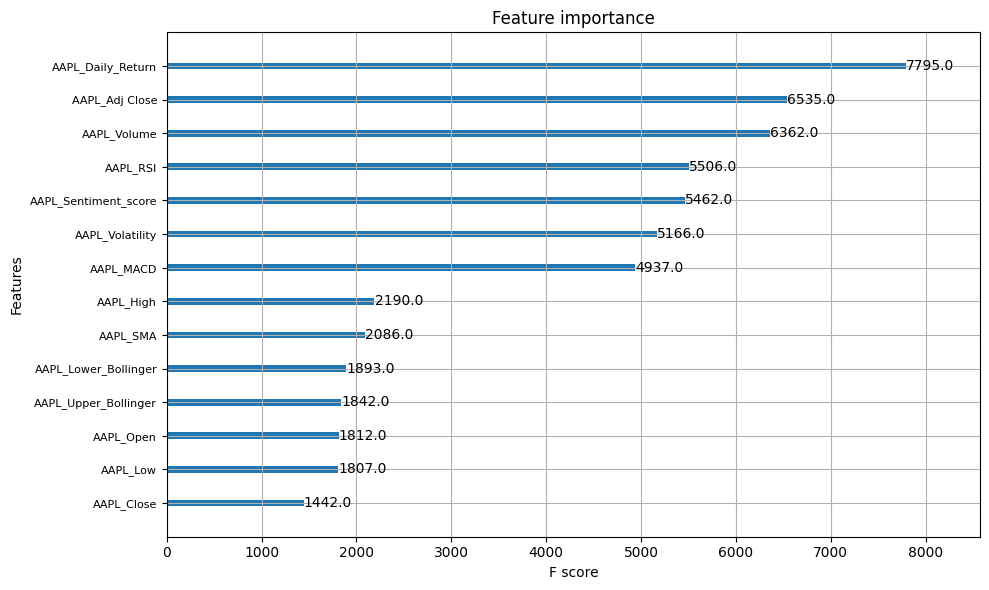

In [226]:
# For AAPL
X = merged[feature_columns_AAPL]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

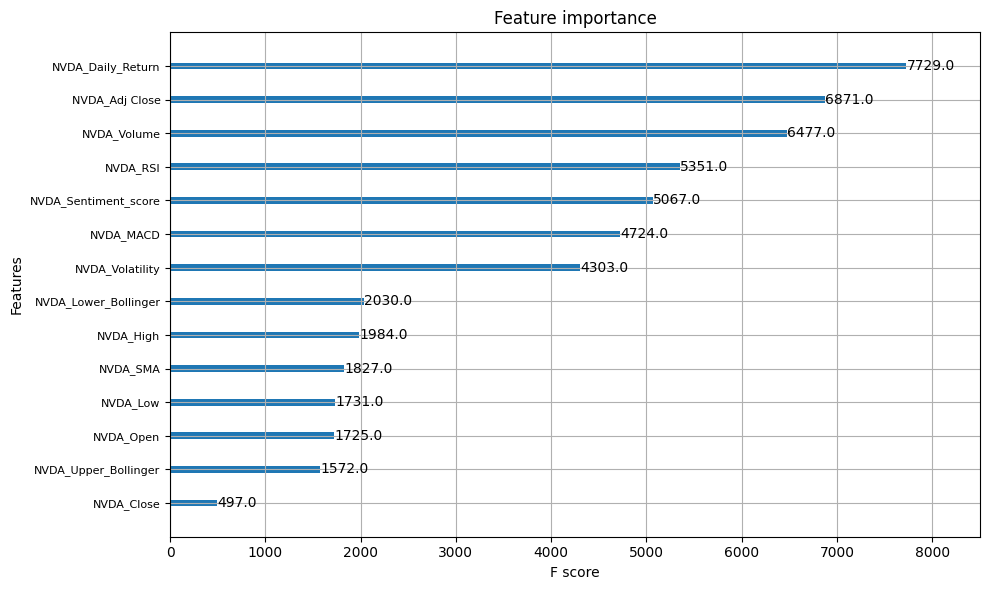

In [227]:
# For NVDA
X = merged[feature_columns_NVDA]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

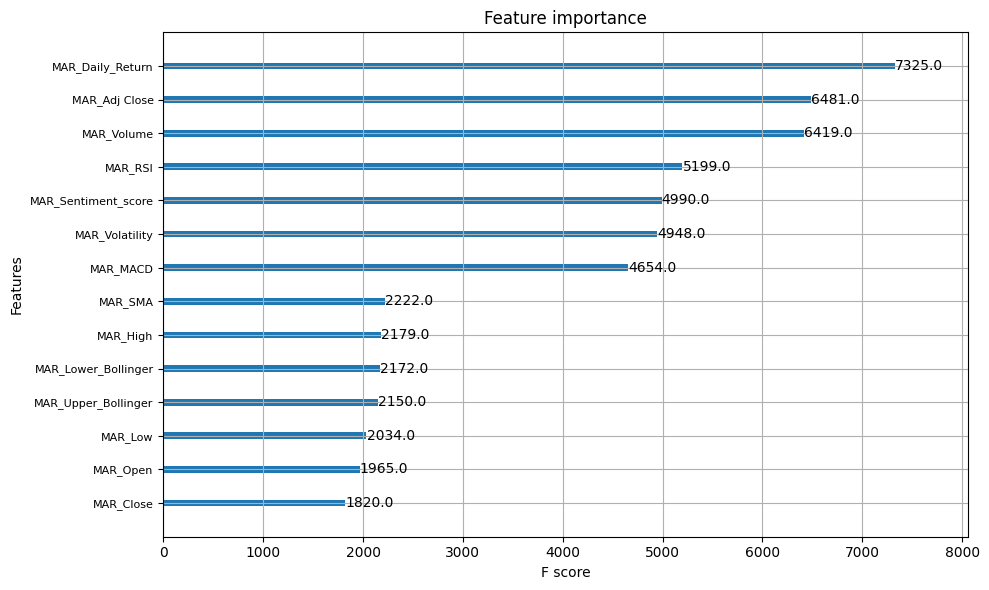

In [228]:
# For MAR
X = merged[feature_columns_MAR]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

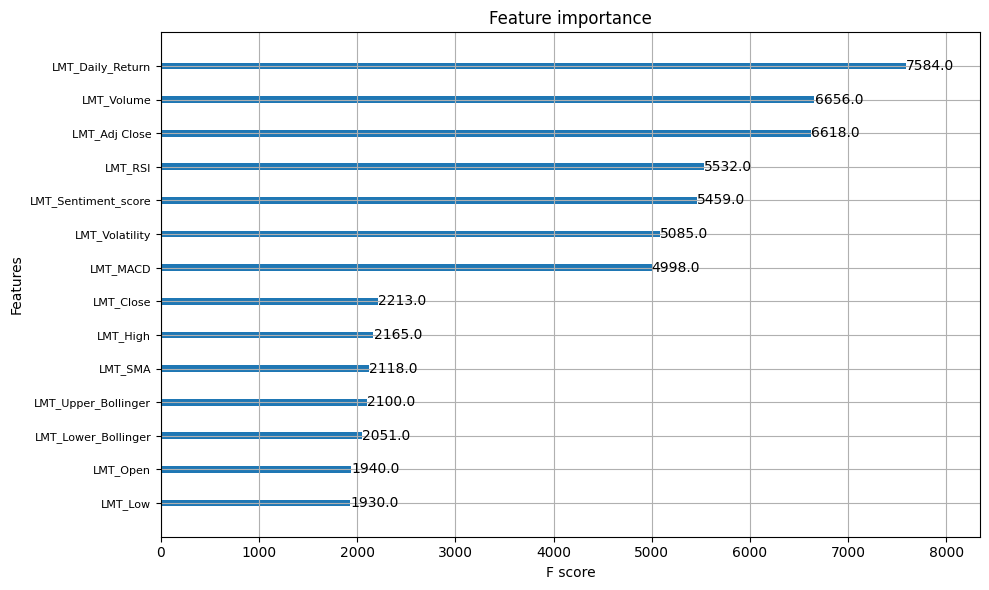

In [229]:
# For LMT
X = merged[feature_columns_LMT]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

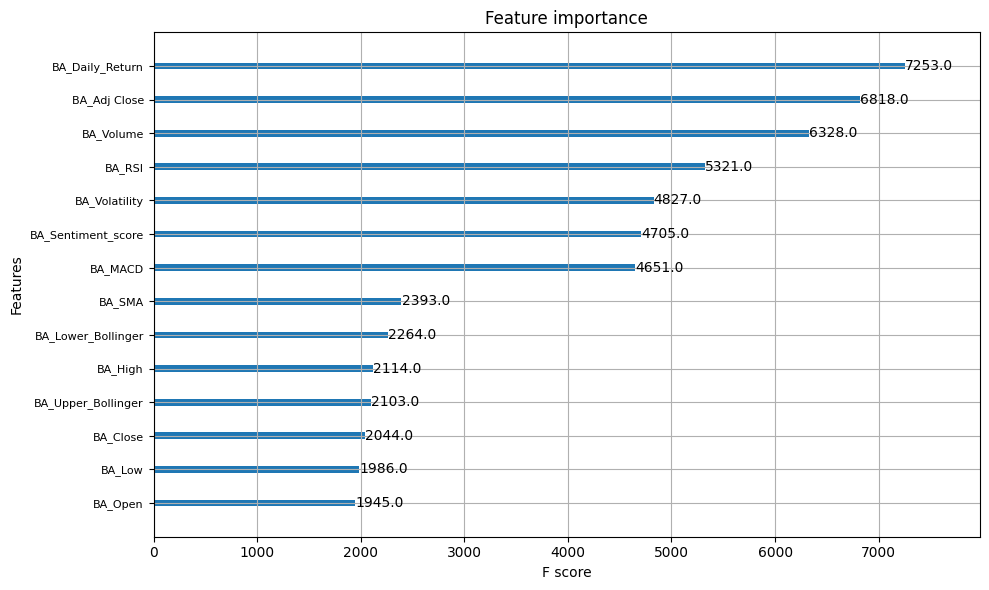

In [230]:
# For BA
X = merged[feature_columns_BA]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

# to run LSTMPreprocess.ipynb after excel output